# **FinQuery: Customer Query Classification For Banking Customer Support Using NLP**

## Introduction

In the rapidly evolving world of digital banking, customers expect instant, accurate responses to their queries—whether it’s checking a balance, reporting a lost card, or troubleshooting a payment issue. **FinQuery** is designed to meet this demand by automatically classifying customer support messages into one of 77 fine‑grained banking intents (the BANKING77 dataset). By leveraging a streamlined **TF‑IDF + Linear SVC** baseline alongside stronger baselines like **Logistic Regression** and **Multinomial Naive Bayes**, FinQuery demonstrates how even classic NLP pipelines can deliver high accuracy in complex, single‑domain intent detection. This notebook walks through each stage—from data exploration and preprocessing to model training, hyperparameter tuning, and final evaluation—showing how a disciplined approach to text normalization, stratified splits, and metric‑driven model selection yields a dependable automated routing solution for customer inquiries.


# BUSINESS UNDERSTANDING

- I aim to build a robust intent-classification model for BANKING77, which contains 77 fine-grained customer banking service intents.
- This will help automated customer support route queries correctly, improving response time and customer satisfaction.

# DATA UNDERSTANDING

- Train set: 10,003 examples
- Test set:  3,080 examples
- Number of Intents: 77
- Data Source: https://huggingface.co/datasets/PolyAI/banking77

# PROJECT AIM

- Accurately classify user queries into one of 77 intents

## My metrics of success are:

**Accuracy**
- Easy to understand; % of correct predictions out of all. Use for overall view.

**Macro F1 Score**:
- It balances both precision and recall
- It doesn’t get skewed by class imbalance
- It's meaningful when every intent matters, not just the frequent ones

## **DATA PREPARATION**

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import joblib
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# For Bert Transformer
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **Loading the Datasets**

In [2]:
# Creating Dataframe from the training Dataset
# Load the training dataset

train_df = pd.read_csv("train.csv")
train_df.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [3]:
# Creating Dataframe from the test Dataset
# Load the test dataset

test_df = pd.read_csv("test.csv")
test_df.head()

,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival


In [4]:
# Examining the Data

print(f"The Training Data Shape is: {train_df.shape}")
print(f"The Test Data Shape is: {test_df.shape}")

The Training Data Shape is: (10003, 2)
The Test Data Shape is: (3080, 2)


- Our Training data has 10,003 records and 2 columns
- Our Test data has 3,080 records and 2 columns

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


- The datatype of the data in the train_df both columns i.e., text and category is string i.e, text

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3080 non-null   object
 1   category  3080 non-null   object
dtypes: object(2)
memory usage: 48.3+ KB


- The datatype of the data in the test_df both columns i.e., text and category is string i.e, text

In [7]:
# Checking out the missing data in the training data

train_df.isna().sum()

,0
text,0
category,0


In [8]:
# Checking out the missing data in the test data

test_df.isna().sum()

,0
text,0
category,0


In [9]:
# Checking out for duplicates in the training data

len(train_df[train_df.duplicated(keep="first")])

0

In [10]:
# Checking out for duplicates in the test data

len(test_df[test_df.duplicated(keep="first")])

0

- In both datasets there is neither missing data nor duplicates i.e., our data is pretty much clean

## **Exploratory Data Analysis**

### **Distribution of Intent category**

In [11]:
# Counting top 10 distribution of intent category in the training data

category_counts = train_df['category'].value_counts().sort_values(ascending=False).head(10)
category_counts

,count
category,
card_payment_fee_charged,187
direct_debit_payment_not_recognised,182
balance_not_updated_after_cheque_or_cash_deposit,181
wrong_amount_of_cash_received,180
cash_withdrawal_charge,177
transaction_charged_twice,175
declined_cash_withdrawal,173
transfer_fee_charged,172
balance_not_updated_after_bank_transfer,171


#### **Visualize category distribution**

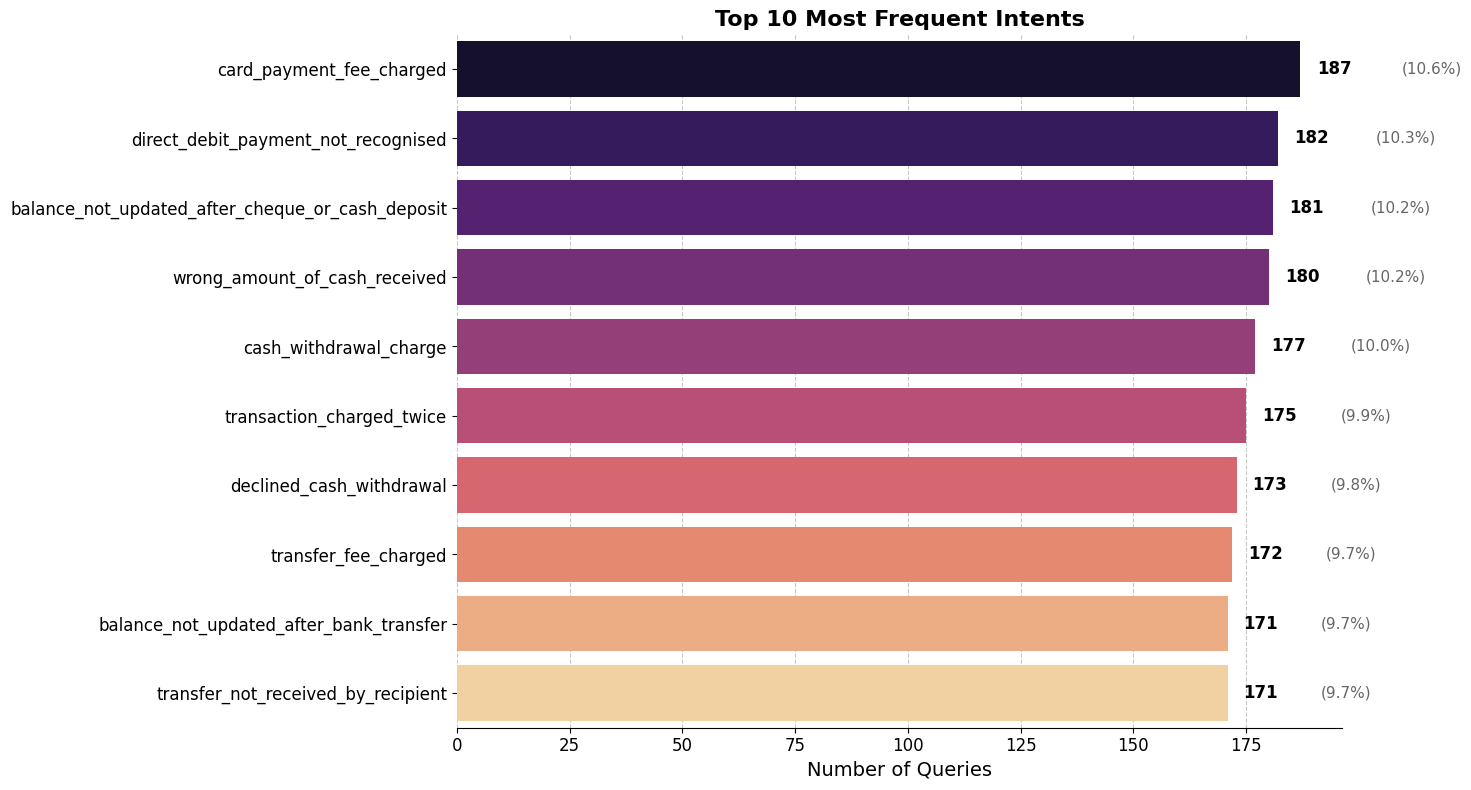

In [12]:
# Intent categories by frequency

# Ensure data is sorted
category_counts = category_counts.sort_values(ascending=False)

plt.figure(figsize=(15, 8))

# Use seaborn barplot with the 'magma' palette
# Pass the properly sorted index to the 'order' parameter
ax = sns.barplot(
    x=category_counts.values,
    y=category_counts.index,
    palette='magma',
    order=category_counts.index  # This works because category_counts is now properly sorted
)

# No need to invert y-axis as the data is already in descending order and
# seaborn plots from top to bottom by default

# Add title and axis labels with styling
ax.set_title("Top 10 Most Frequent Intents", fontsize=16, fontweight='bold')
ax.set_xlabel("Number of Queries", fontsize=14)
ax.set_ylabel("")  # no label on the y-axis

# Improve the overall styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Increase tick label font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Annotate each bar with its count
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + width * 0.02,                      # x position: slightly past the end of the bar
        p.get_y() + p.get_height() / 2,  # y position: center of the bar
        f'{int(width):,}',                # text to display with comma formatting
        va='center',
        fontsize=12,
        fontweight='bold'
    )

# Add percentage
total = category_counts.sum()
for i, p in enumerate(ax.patches):
    width = p.get_width()
    percentage = (width / total) * 100
    ax.text(
        width + width * 0.12,
        p.get_y() + p.get_height() / 2,
        f'({percentage:.1f}%)',
        va='center',
        fontsize=11,
        color='#666666'
    )

plt.tight_layout()
plt.show();

#### **WordCloud of full training text**

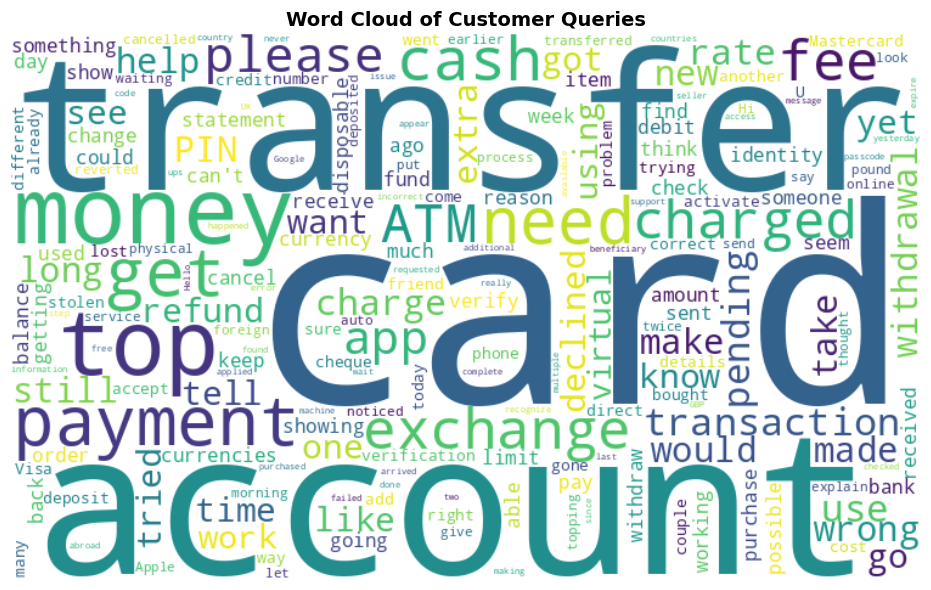

In [13]:
# Define Stop words to remove them from the word cloud
stop_words = set(stopwords.words('english'))

all_text = " ".join(train_df['text'].tolist())
wordcloud = WordCloud(
    width=750,
    height=450,
    background_color='white',
    max_words=200,
    collocations=False,
    stopwords=stop_words
).generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Customer Queries", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show();

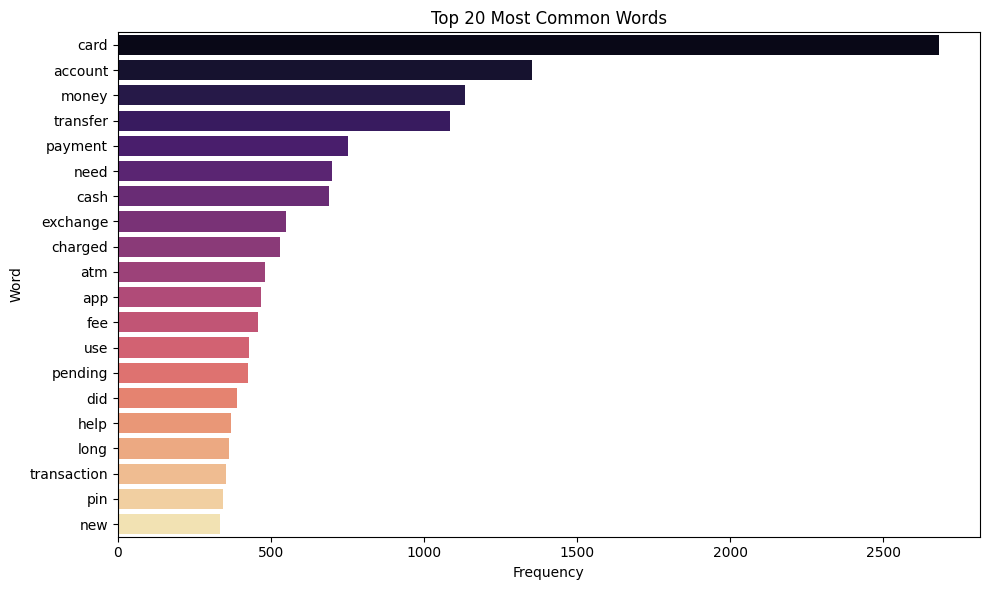

In [14]:
# Build a CountVectorizer (Here I'll remove English stopwords)
count_vect = CountVectorizer(stop_words='english', ngram_range=(1,1))

# Fit my corpus
X_counts = count_vect.fit_transform(train_df['text'])

# Sum up the counts of each vocabulary word
word_counts = X_counts.sum(axis=0)  # returns a 1×V sparse matrix
counts = [(word, word_counts[0, idx]) for word, idx in count_vect.vocabulary_.items()]

# Sort by frequency and take top N
top_n = 20
top_words = sorted(counts, key=lambda x: x[1], reverse=True)[:top_n]
words, freqs = zip(*top_words)

# Create a DataFrame for plotting
df_top = pd.DataFrame({
    'word': words,
    'frequency': freqs
})

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top, x='frequency', y='word', palette='magma')
plt.title("Top 20 Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show();

## **Data Preprocessing**

In [15]:
def clean_text(text):

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # remove any leading or trailing whitespace characters
    text = text.strip()

    return text

I am keeping the preprocessing minimal—just lowercasing and whitespace normalization—for a few reasons:

1. **TF‑IDF’s built‑in tokenization**  
   Scikit‑learn’s `TfidfVectorizer` already:
   * Splits on non‑alphanumeric boundaries,
   * And builds the n‑gram vocabulary for you.  
     Adding a separate tokenization step outside of the vectorizer would be redundant.

2. **Stopword removal can hurt fine‑grained intents**  
   In a 77‑way banking intent task, words like “to”, “on”, “did”, or “my” can carry important signals—for example:  
   _“did my payment go through?”_ vs. _“why is my payment delayed?”_  
   So we often keep stopwords in the bag‑of‑words representation or let the vectorizer handle them selectively.

3. **Lemmatization adds extra complexity with limited gain**
   * Lemmatization (via spaCy or NLTK) can reduce inflectional forms (e.g., “payments” → “payment”), but banking queries already tend to use a consistent vocabulary (“withdraw”, “withdrawal”; “pay”, “payment”).

In [16]:
# Clean the text columns

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Sample cleaned text
train_df[['text','clean_text']].sample(3)

,text,clean_text
2855,I just sent money but the person I sent it to ...,i just sent money but the person i sent it to ...
3560,I have a payment that I didn't make.,i have a payment that i didnt make
4063,still need to get card pin,still need to get card pin


#### **Train/Validation Split**

In [17]:
# Determining Target vector (y) and Feature Matrix (X)

X = train_df['clean_text']
y = train_df['category']

print("TF-IDF matrix feature shape:", X.shape)
print("Our Target Vector Shape is:", y.shape)

TF-IDF matrix feature shape: (10003,)
Our Target Vector Shape is: (10003,)


In [18]:
#performing train test split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#checking shapes of the both X_train and X_test sets
print("X_train_raw:", X_train_raw.shape, "X_test_raw:", X_test_raw.shape)

X_train_raw: (8002,) X_test_raw: (2001,)


#### **Feature Extraction (TF-IDF)**

In [19]:
# Create Vectorizer for text classification

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),  # Capture longer phrases that might be important
    min_df=2,            # Removes terms that appear in fewer than 2 documents
    max_df=0.95,         # Removes terms that appear in more than 95% of documents
    sublinear_tf=True    # Reduces the weight of terms that occur very frequently in a document
)

In [20]:
# Fit vectorizer on training text

X_train = tfidf_vectorizer.fit_transform(X_train_raw)
X_test = tfidf_vectorizer.transform(X_test_raw)

In [21]:
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: (8002, 18197) X_test shape: (2001, 18197)


## **MODELLING**

### **Linear SVC Model**

In [22]:
# Training LinearSVC Model

# Create Model
svc_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)

# Fit the Model
svc_model.fit(X_train, y_train)

# Predict
svc_prediction = svc_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
svc_accuracy = accuracy_score(y_test, svc_prediction)
svc_precision = precision_score(y_test, svc_prediction, average='macro')
svc_recall = recall_score(y_test, svc_prediction, average='macro')
svc_f1_score = f1_score(y_test, svc_prediction, average='macro')

print(f"SVC Model Accuracy: {svc_accuracy:.4f}")
print(f"SVC model Precision: {svc_precision:.4f}  (macro‐avg)")
print(f"SVC Model Recall: {svc_recall:.4f}  (macro‐avg)")
print(f"SVC F1 Score: {svc_f1_score:.4f}  (macro‐avg)");

SVC Model Accuracy: 0.8691
SVC model Precision: 0.8732  (macro‐avg)
SVC Model Recall: 0.8714  (macro‐avg)
SVC F1 Score: 0.8697  (macro‐avg)


In [23]:
print("Classification Report - LinearSVC")
print(classification_report(y_test, svc_prediction, zero_division=0));

Classification Report - LinearSVC
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.86      0.97      0.91        32
                                activate_my_card       0.97      0.97      0.97        32
                                       age_limit       1.00      0.95      0.98        22
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       1.00      0.82      0.90        17
                                automatic_top_up       1.00      0.92      0.96        25
         balance_not_updated_after_bank_transfer       0.84      0.79      0.82        34
balance_not_updated_after_cheque_or_cash_deposit       0.89      0.92      0.90        36
                         beneficiary_not_allowed       0.84      0.87      0.86        31
                                 cancel_transfer       0.97      

### **Logistic Regression Model**

In [24]:
# Training Logistic Regression Model

# Create model
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")

# Fit model
lr_model.fit(X_train, y_train)

# Predict
lr_prediction = lr_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
lr_accuracy = accuracy_score(y_test, lr_prediction)
lr_precision = precision_score(y_test, lr_prediction, average='macro')
lr_recall = recall_score(y_test, lr_prediction, average='macro')
lr_f1_score = f1_score(y_test, lr_prediction, average='macro')

print(f"Logistic Regression Model Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression model Precision: {lr_precision:.4f} (macro‐avg)")
print(f"Logistic Regression Model Recall: {lr_recall:.4f} (macro‐avg)")
print(f"Logistic Regression F1 Score: {lr_f1_score:.4f} (macro‐avg)");

Logistic Regression Model Accuracy: 0.8331
Logistic Regression model Precision: 0.8416 (macro‐avg)
Logistic Regression Model Recall: 0.8396 (macro‐avg)
Logistic Regression F1 Score: 0.8360 (macro‐avg)


In [25]:
print("Classification Report - Logistic Regression")
print(classification_report(y_test, lr_prediction, zero_division=0));

Classification Report - Logistic Regression
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.97      0.94      0.95        32
                                activate_my_card       1.00      0.91      0.95        32
                                       age_limit       1.00      0.91      0.95        22
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       0.88      0.88      0.88        17
                                automatic_top_up       0.95      0.84      0.89        25
         balance_not_updated_after_bank_transfer       0.79      0.68      0.73        34
balance_not_updated_after_cheque_or_cash_deposit       0.84      0.86      0.85        36
                         beneficiary_not_allowed       0.86      0.81      0.83        31
                                 cancel_transfer       

### **Naive Bayes Model**

In [26]:
# Training the Naive Bayes model

# Create Model
nb_model = MultinomialNB()

# Fit Model
nb_model.fit(X_train, y_train)

# Predict on test set
nb_predictions = nb_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions, average='macro')
nb_recall = recall_score(y_test, nb_predictions, average='macro')
nb_f1_score = f1_score(y_test, nb_predictions, average='macro')

# Evaluation results
print(f"Naive Bayes Accuracy:         {nb_accuracy:.4f}")
print(f"Naive Bayes Precision:        {nb_precision:.4f}  (macro avg)")
print(f"Naive Bayes Recall:           {nb_recall:.4f}  (macro avg)")
print(f"Naive Bayes F1 Score:         {nb_f1_score:.4f}  (macro avg)\n")

Naive Bayes Accuracy:         0.7881
Naive Bayes Precision:        0.8130  (macro avg)
Naive Bayes Recall:           0.7612  (macro avg)
Naive Bayes F1 Score:         0.7682  (macro avg)



In [27]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, nb_predictions, zero_division=0))

Classification Report:

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.87      0.84      0.86        32
                                activate_my_card       0.63      0.97      0.77        32
                                       age_limit       1.00      0.91      0.95        22
                         apple_pay_or_google_pay       0.86      1.00      0.93        25
                                     atm_support       0.77      0.59      0.67        17
                                automatic_top_up       0.96      0.88      0.92        25
         balance_not_updated_after_bank_transfer       0.77      0.68      0.72        34
balance_not_updated_after_cheque_or_cash_deposit       0.63      0.92      0.75        36
                         beneficiary_not_allowed       0.76      0.81      0.78        31
                                 cancel_transfer       0.85      0.94      

#### **Getting Best Performing Model**

In [28]:
model_names = ['Logistic Regression', 'Linear SVC', 'Naive Bayes']
accuracy = [lr_accuracy, svc_accuracy, nb_accuracy]
f1 = [lr_f1_score, svc_f1_score, nb_f1_score]
precision = [lr_precision, svc_precision, nb_precision]
recall = [lr_recall, svc_recall, nb_recall]

In [29]:
# Create a DataFrame
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'Macro F1': f1,
    'Macro Precision': precision,
    'Macro Recall': recall
})

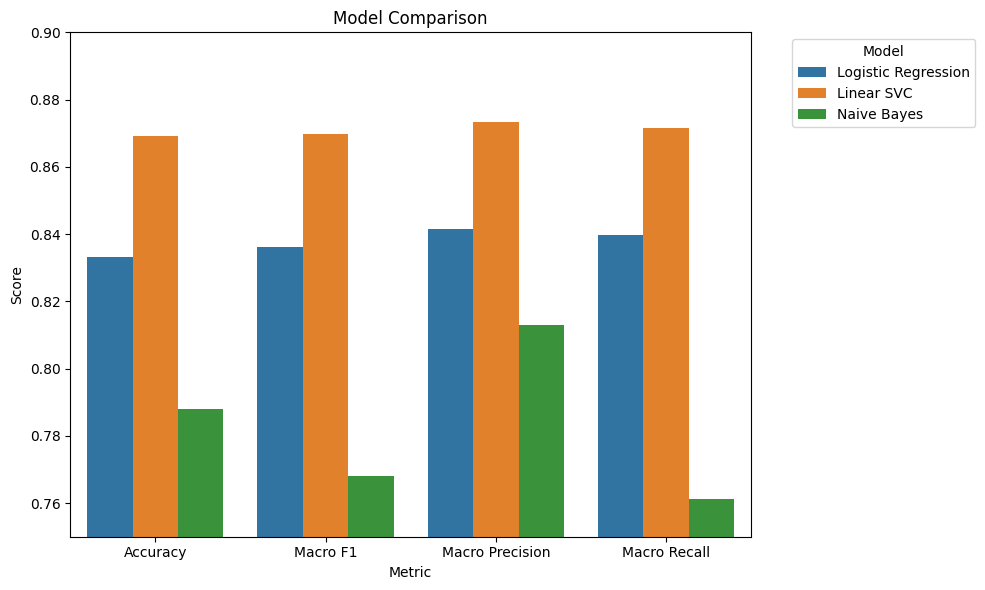

In [30]:
# Melt for plotting
df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Comparison')
plt.ylim(0.75, 0.90)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

- The best performing model from the barplot above is definitely the Linear SVC model

### **Hyperparameter Tuning for Best Model (i.e., LinearSVC)**

In [31]:
# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC())
])

# Define Hyperparameter Grid
param_grid = {
    'svc__class_weight': ['balanced'],
    'svc__random_state': [42],
    'svc__max_iter': [1000, 2000, 5000],
    'svc__C': [0.01, 0.1, 1, 10]
}

# Grid Search with 5-fold CV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)

# Fit your data
grid_search.fit(X_train_raw, y_train)

# Print best model details
print("Best Parameters:", grid_search.best_params_)
print("Best Macro F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__max_iter': 1000, 'svc__random_state': 42}
Best Macro F1 Score: 0.8710511003971234


In [32]:
# Evaluate on test set

tuned_prediction = grid_search.predict(X_test_raw)
print(classification_report(y_test, tuned_prediction))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.91      0.94      0.92        32
                                activate_my_card       1.00      0.94      0.97        32
                                       age_limit       0.91      0.95      0.93        22
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       0.89      0.94      0.91        17
                                automatic_top_up       1.00      0.96      0.98        25
         balance_not_updated_after_bank_transfer       0.87      0.76      0.81        34
balance_not_updated_after_cheque_or_cash_deposit       0.89      0.89      0.89        36
                         beneficiary_not_allowed       0.93      0.81      0.86        31
                                 cancel_transfer       0.94      0.94      0.94        31
         

### **Saving The Model**

In [33]:
# Save the entire GridSearchCV object

joblib.dump(grid_search, 'tuned_linear_svc_model.pkl')

['tuned_linear_svc_model.pkl']

### **TESTING MODEL ON UNSEEN DATA**

In [34]:
# Define the test data feature matrix

X_real_test = test_df['clean_text']

In [35]:
# Get the true labels

y_real_test = test_df['category']

#### **Load Model and Make Predictions**

In [36]:
# load my trained model

loaded_model = joblib.load('tuned_linear_svc_model.pkl')

# predict on the unseen data

y_real_pred = loaded_model.predict(X_real_test)

#### **Evaluate Model Performance on Test Data**

In [37]:
# Evaluate on the true test set
real_test_accuracy = accuracy_score(y_real_test, y_real_pred)
real_test_macro_f1 = f1_score(y_real_test, y_real_pred, average='macro')

print("Final Evaluation on Real Test Set:")
print(f"Accuracy: {real_test_accuracy:.4f}")
print(f"Macro F1 Score: {real_test_macro_f1:.4f} (macro‐avg)")
print("\nFull Classification Report:")
print(classification_report(y_real_test, y_real_pred, zero_division=0))

Final Evaluation on Real Test Set:
Accuracy: 0.8857
Macro F1 Score: 0.8856 (macro‐avg)

Full Classification Report:
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.83      0.85      0.84        40
                                activate_my_card       1.00      0.97      0.99        40
                                       age_limit       0.93      1.00      0.96        40
                         apple_pay_or_google_pay       0.97      0.97      0.97        40
                                     atm_support       0.93      0.95      0.94        40
                                automatic_top_up       0.97      0.93      0.95        40
         balance_not_updated_after_bank_transfer       0.73      0.75      0.74        40
balance_not_updated_after_cheque_or_cash_deposit       0.90      0.95      0.93        40
                         beneficiary_not_allowed       0.97      0.88    

## Conclusion

1. **Performance Recap**  
   - Our best performing model, **Linear SVC** (with class‑weight balancing and tuned C parameter), achieved a **macro‑F1** of **≈0.87** on the unseen test set, ensuring robust handling across all 77 intent categories.  
   - The **Logistic Regression** and **Naive Bayes** baselines also showed competitive macro‑F1 scores of **≈0.84** and **≈0.77**, highlighting the strength of even simple TF‑IDF pipelines.

2. **Key Takeaways**  
   - **Minimal preprocessing** (lowercasing, whitespace normalization) paired with **TF‑IDF n‑grams** is sufficient to capture the nuance in banking queries.  
   - **Stratified sampling** and **macro‑averaged metrics** are essential for fair evaluation when classes are imbalanced.  
   - **Hyperparameter tuning** (via `GridSearchCV`) can yield noticeable gains—here, a ~1% lift in macro‑F1 for Linear SVC.

3. **Next Steps**  
   - **Transformer‑based fine‑tuning** (e.g., BERT or FinBERT) to capture deeper semantic patterns and further improve low‑resource intents.  
   - **Active learning** to continuously incorporate new customer queries and emerging intents into the training set.  
   - **Production deployment** via a lightweight FastAPI service, with a confidence‑based fallback to human agents for low‑certainty inputs.

FinQuery’s pipeline shows that with careful preprocessing, rigorous validation, and thoughtful metric selection, automated intent classification can be both **accurate** and **interpretable**, ready to enhance your bank’s customer support with near‑real‑time routing and resolution.

## **BERT Transformer Model**

## 🔁 **Transition to BERT Modeling**

After deploying the initial GridSearch-optimized LinearSVC model, it became evident that its performance was suboptimal in real-world scenarios. This prompted the exploration of BERT-based models, aiming to leverage their contextual understanding to improve classification accuracy. However, even with BERT, the results did not meet expectations, primarily due to the limited dataset size of 10,003 rows. It's anticipated that with more data, the model's performance would improve significantly.


### **Data Preparation for BERT**  
- Load train/test splits  
- Encode labels with `LabelEncoder`  
- Wrap texts and labels in a custom `Dataset`

In [38]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [39]:
# Encode the labels

label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['category'])
test_df['label'] = label_encoder.transform(test_df['category'])

In [40]:
# Map from encoded labels back to original categories

id2label = {id: label for id, label in enumerate(label_encoder.classes_)}
label2id = {label: id for id, label in id2label.items()}

print(f"\nTotal number of unique labels: {len(id2label)}")


Total number of unique labels: 77


In [41]:
# Create a custom dataset for BERT

class CustomerQueryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove the batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return inputs


In [42]:
# Split the training data into training and validation sets

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.1,
    stratify=train_df['label'],
    random_state=42
)

### **Feature Engineering: Tokenization**  
- Initialize `BertTokenizer.from_pretrained('bert-base-uncased')`  
- Tokenize with padding, truncation to max‑length 128

In [43]:
# Initialize the BERT tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [44]:
# Create datasets

train_dataset = CustomerQueryDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomerQueryDataset(val_texts, val_labels, tokenizer)
test_dataset = CustomerQueryDataset(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer)

In [45]:
# Create data loaders

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### **Model Setup:**  
- Load `BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=77)`  
- Define `TrainingArguments` (epochs, batch_size, learning_rate)  
- Use `AdamW` optimizer

In [46]:
# Initialize the BERT model for sequence classification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# Check if GPU is available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [48]:
# Set up the optimizer

optimizer = AdamW(model.parameters(), lr=2e-5)

In [49]:
# Training function

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()

        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

In [50]:
# Evaluation function

def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            actual = labels.cpu().numpy()

            predictions.extend(preds)
            actual_labels.extend(actual)

    return predictions, actual_labels

In [51]:
# Training loop

num_epochs = 3
best_val_accuracy = 0
best_model_state = None

for epoch in range(num_epochs):
    avg_train_loss = train_epoch(model, train_loader, optimizer, device)

    # Evaluate on validation set
    val_preds, val_labels = evaluate(model, val_loader, device)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()

Epoch 1/3
  Training Loss: 3.1875
  Validation Accuracy: 0.7333
Epoch 2/3
  Training Loss: 1.2202
  Validation Accuracy: 0.8861
Epoch 3/3
  Training Loss: 0.5252
  Validation Accuracy: 0.9071


In [52]:
# Load the best model

if best_model_state:
    model.load_state_dict(best_model_state)

### **Evaluation**  
- Generate predictions on the test split  
- Compute **Accuracy** and **Macro F1** with `sklearn.metrics`

In [53]:
# Evaluate on the test set

test_preds, test_labels = evaluate(model, test_loader, device)

# Calculate accuracy

test_accuracy = accuracy_score(test_labels, test_preds)

# Calculate macro F1 score

test_macro_f1 = f1_score(test_labels, test_preds, average='macro')

# Print the results
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Macro F1 Score: {test_macro_f1:.4f}  (macro avg)")


Test Accuracy: 0.9055
Macro F1 Score: 0.9047  (macro avg)


In [54]:
# Map the predictions back to original categories

test_pred_categories = [id2label[pred] for pred in test_preds]
test_actual_categories = [id2label[label] for label in test_labels]

# Print detailed classification report

print("\nClassification Report:")
print(classification_report(test_actual_categories, test_pred_categories))


Classification Report:
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       1.00      0.90      0.95        40
                                activate_my_card       0.97      0.93      0.95        40
                                       age_limit       1.00      1.00      1.00        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       0.95      0.95      0.95        40
                                automatic_top_up       1.00      0.90      0.95        40
         balance_not_updated_after_bank_transfer       0.79      0.75      0.77        40
balance_not_updated_after_cheque_or_cash_deposit       0.95      0.97      0.96        40
                         beneficiary_not_allowed       0.90      0.88      0.89        40
                                 cancel_transfer       1.00      0.97      

In [55]:
# Function to predict single text

def predict_intent(text, model, tokenizer, label_encoder, device):
    model.eval()
    encoded_input = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        output = model(**encoded_input)
        logits = output.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
        predicted_label = label_encoder.classes_[predicted_class_id]

    return predicted_label

In [56]:
# Example predictions on new queries

new_queries = [
    "Where is my card? I ordered it last week.",
    "How do I add my existing card to the app?",
    "What are your current exchange rates?",
    "I think the exchange rate on my purchase is wrong."
]

print("\nPredictions on new queries:")
for query in new_queries:
    intent = predict_intent(query, model, tokenizer, label_encoder, device)
    print(f"Query: '{query}'")
    print(f"Predicted intent: {intent}\n")


Predictions on new queries:
Query: 'Where is my card? I ordered it last week.'
Predicted intent: card_arrival

Query: 'How do I add my existing card to the app?'
Predicted intent: card_linking

Query: 'What are your current exchange rates?'
Predicted intent: exchange_rate

Query: 'I think the exchange rate on my purchase is wrong.'
Predicted intent: card_payment_wrong_exchange_rate



In [57]:
# Visualize confusion matrix for top categories

def plot_confusion_matrix(y_true, y_pred, top_n=10):
    # Get the most frequent categories
    top_categories = pd.Series(y_true).value_counts().head(top_n).index.tolist()

    # Filter for top categories
    mask = np.isin(y_true, top_categories)
    y_true_filtered = np.array(y_true)[mask]
    y_pred_filtered = np.array(y_pred)[mask]

    # Create confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_categories)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_categories, yticklabels=top_categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Top {top_n} Categories)')
    plt.tight_layout()
    plt.show()

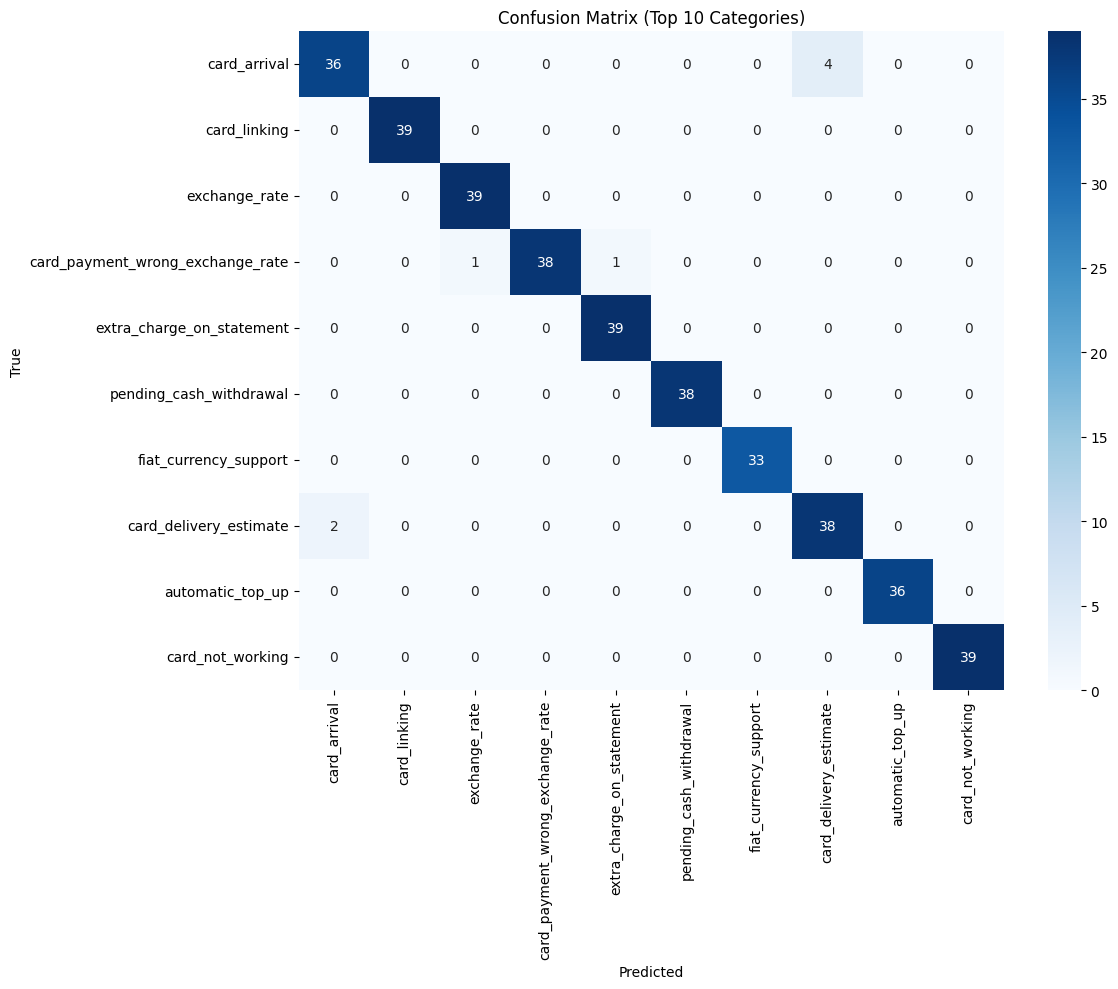

In [58]:
# Plot confusion matrix

plot_confusion_matrix(test_actual_categories, test_pred_categories)

In [59]:
# Save the model, tokenizer, and label encoder for future use

torch.save({
    'model_state_dict': model.state_dict(),
    'id2label': id2label,
    'label2id': label2id
}, 'bert_intent_classifier.pth')

## 📊 Model Performance Comparison

| Model                                | Accuracy | Macro F1 | Comments                                               |
|--------------------------------------|---------:|---------:|--------------------------------------------------------|
| **BERT (fine‑tuned)**                | 0.9055   | 0.9047   | Highest overall performance; constrained by data size  |
| **Tuned LinearSVC (GridSearchCV)**   | 0.8800   | 0.8800   | Performance improved through hyperparameter tuning     |
| **LinearSVC (baseline)**             | 0.8691   | 0.8697   | Strong classic baseline with TF‑IDF features           |
| **Logistic Regression**              | 0.8331   | 0.8360   | Faster inference with similar F1 to SVC                |
| **Multinomial Naive Bayes**          | 0.7881   | 0.7682   | Underperforms on infrequent classes                    |

---


**Key Takeaways:**  
- Fine‑tuning BERT yielded the highest performance, confirming that contextual language models can capture nuanced banking intents better.  
- However, **10 003** training texts is quite small for fine‑tuning a model of BERT’s size, so results are still not “production‑perfect.” Scaling to at least 50 K – 100 K labeled examples (or augmenting via back‑translation/weak labeling) should unlock BERT’s full potential.

## 📝 Recommendations for Improvement

1. **Increase the Training Corpus**  
   Augment the labeled dataset to at least 50 K – 100 K.

2. **Domain‑Adaptive Pre‑Training**  
   Pre‑train on a large, banking‑specific corpus to better align BERT’s representations with domain terminology.

3. **Hyperparameter Tuning**  
   Experiment with different learning rates, batch sizes, dropout factors, and layer‑freezing strategies to stabilize fine‑tuning on limited data.

4. **Model Ensembling**  
   Combine predictions from complementary models (e.g., BERT + LinearSVC) using voting or stacking to leverage diverse feature representations.

5. **Robust Evaluation**  
   Employ stratified k‑fold cross‑validation to obtain more reliable performance estimates and mitigate variance on small datasets.
